In [1]:
using Revise
using Random
using Plots  # Optional, for plotting

In [2]:
using PauliPropagation

## Example of using `symmetrypropagate` to propagate a Pauli operator through a circuit

This subsection is included in `test_symmetrymerge.jl`

In [3]:
Random.seed!(42) # for 
nq = 3  # number of qubits
nl = 2  # number of layers
W = Inf;                   # maximal operator weight.
min_abs_coeff = 0;          # neglect small coefficients. Only for numerical and hybrid PP.
thetax, thetaz, thetay = randn(nl), randn(nl), randn(nl)
thetas = theta_periodic_brickwork(nq, nl, thetax, thetaz, thetay);
# Observable to compute the expectation value of:
symbs = [:I for _ in 1:nq]
symbs[round(Integer, nq/2)] = :Z   # as symbol. Also works but is slower.
obsint = symboltoint(symbs);  # for performance we work with bitoperations

In [4]:
# Build single layer of translational invariant brickwork circuit
topo = bricklayertopology(nq, periodic=true)  # periodic boundary conditions
circ_layer = hardwareefficientcircuit(nq, 1; topology=topo)
fastcirc_layer = tofastgates(circ_layer)
thetas_layers = reshape(thetas, :, nl);
symbfs = symmetrypropagate(fastcirc_layer, obsint, thetas_layers, nq, nl, W, min_abs_coeff)
# Compare with numerical propagation
full_circuit = hardwareefficientcircuit(nq, nl; topology=topo)
fastfull_circuit = tofastgates(full_circuit)
numbfs  = mergingbfs(fastfull_circuit, obsint, thetas, max_weight=W, min_abs_coeff=min_abs_coeff);

In [5]:
# Check the expectation value from symmetry propagation and numerical propagation are the same
evsym = evalagainstzero(symbfs) # expectation
evnum = evalagainstzero(numbfs) # expectation
@assert isapprox(evnum, evsym; atol=1e-8) "Numerical value $evnum is not equal to symmetry value $evsym for nq = $nq"
evsym - evnum


1.1102230246251565e-16

## Performance comparison

In [3]:
function compare_numerical_symmetry(qubits, layers)
  timed_numerical = Dict()
  timed_symmetry = Dict()
  W = Inf;                   # maximal operator weight.
  min_abs_coeff = 0;          # neglect small coefficients. Only for numerical and hybrid PP.
  for nq in qubits
      # Observable to compute the expectation value of:
      symbs = [:I for _ in 1:nq]
      symbs[round(Integer, nq/2)] = :Z   # as symbol. Also works but is slower.
      obsint = symboltoint(symbs)  # for performance we work with bitoperations
      # println("observable string: ", join(symbs))
      for nl in layers
          #YT: currently if topology and nq are not consistent, the code will throw an error.
          # Consider adding a check to make sure topology and nq are compatible. 
          topo = bricklayertopology(nq, periodic=true)  # periodic boundary conditions
          # Build brickwork circuit
          circ = hardwareefficientcircuit(nq, nl; topology=topo)
          fastcirc = tofastgates(circ)
          thetas = theta_periodic_brickwork(nq, nl, randn(nl), randn(nl), randn(nl));
          t_numerical = @timed mergingbfs(fastcirc, obsint, thetas; max_weight=W, min_abs_coeff=min_abs_coeff);
          ev_numerical = evalagainstzero(t_numerical.value)
          # push!(times_numerical, t_numerical.time)
          timed_numerical[(nq, nl)] = t_numerical

          # Build single layer of translational invariant brickwork circuit
          circ_layer = hardwareefficientcircuit(nq, 1; topology=topo)
          fastcirc_layer = tofastgates(circ_layer)
          thetas_layers = reshape(thetas, :, nl);
          t_symmetry = @timed symmetrypropagate(fastcirc_layer, obsint, thetas_layers, nq, nl, W, min_abs_coeff)
          ev_symmetry = evalagainstzero(t_symmetry.value)
          # push!(times_symmetry, t_symmetry.time)
          timed_symmetry[(nq, nl)] = t_symmetry

          # Check numerical and symmetry expectation are the same
          @assert isapprox(ev_numerical, ev_symmetry; atol=1e-5) "Numerical value $ev_numerical is not equal to symmetry value $ev_symmetry for nq = $nq"
      end
  end
return timed_numerical, timed_symmetry
end


compare_numerical_symmetry (generic function with 1 method)

In [15]:
Random.seed!(42) # for reproducibility
layers = [1, 6, 9]
qubits = [5, 7, 11]
timed_numerical, timed_symmetry = compare_numerical_symmetry(qubits, layers)

(Dict{Any, Any}((11, 9) => (value = Dict{UInt32, Float64}(0x001bf9ef => -9.521013138453853e-5, 0x003db642 => 0.0002141794941760806, 0x002ed6c1 => -0.0007288671499620569, 0x0012991f => -0.0005007446459476157, 0x0025323e => -0.00012725151096384344, 0x0019d339 => 0.0002445413196653908, 0x0021f24e => 0.0001916375907070386, 0x000686a1 => 0.000153728530926933, 0x001e6e43 => 0.000302360821725622, 0x0037f3de => 0.00010313350587901121…), time = 103.573673345, bytes = 577023440, gctime = 0.0, gcstats = Base.GC_Diff(577023440, 83, 0, 906, 30, 0, 0, 0, 0)), (5, 1) => (value = Dict{UInt16, Float64}(0x0005 => -0.170418784743075, 0x0038 => -0.21891766755750694, 0x0037 => 0.21533371054591666, 0x0014 => -0.17041878474307504, 0x003c => 0.22021638316341682, 0x001e => -0.0105003551593035, 0x0006 => -0.05840793502031463, 0x002d => -0.010500355159303507, 0x002c => 0.05009301961191072, 0x001f => -0.04616112690007071…), time = 3.1293e-5, bytes = 6240, gctime = 0.0, gcstats = Base.GC_Diff(6240, 0, 0, 61, 0, 0,

In [19]:
# Extract time only as a dictionary
times_numerical = Dict(k => v.time for (k, v) in timed_numerical)
times_symmetry = Dict(k => v.time for (k, v) in timed_symmetry)
# Extract memory only as a dictionary
memory_numerical = Dict(k => v.bytes for (k, v) in timed_numerical)
memory_symmetry = Dict(k => v.bytes for (k, v) in timed_symmetry);


Number of qubits: [5, 7, 11]
Numerical times: Dict((11, 6) => 32.040180317, (5, 1) => 3.1293e-5, (7, 1) => 2.991e-5, (5, 6) => 0.007458022, (5, 9) => 0.019620504, (11, 1) => 4.1812e-5, (7, 6) => 0.13625316, (7, 9) => 0.34454939, (11, 9) => 103.573673345)
Symmetry times: Dict((11, 6) => 35.47457776, (5, 1) => 3.5632e-5, (7, 1) => 4.5375e-5, (5, 6) => 0.01350334, (5, 9) => 0.015887544, (11, 1) => 0.000111777, (7, 6) => 0.12260996, (7, 9) => 0.237646029, (11, 9) => 111.734570956)


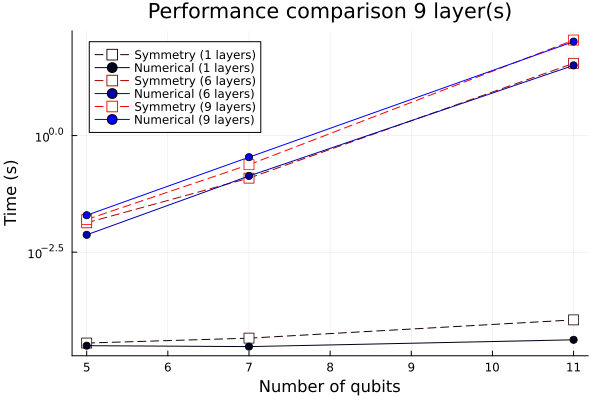

In [20]:

# Print the results
println("Number of qubits: ", qubits)
println("Numerical times: ", times_numerical)
println("Symmetry times: ", times_symmetry)

# Create an empty plot 
Plot = plot()

# Plot the performance as a function of parameter `n`
for d in layers
    times_numerical_n = [times_numerical[(n, d)] for n in qubits]
    times_symmetry_n = [times_symmetry[(n, d)] for n in qubits]
    # Display d in different gradient of color
    colors_numerical = [RGB(0, 0, d/maximum(layers)) for _ in 1:length(qubits)]
    colors_symmetry = [RGB(d/maximum(layers), 0, 0) for _ in 1:length(qubits)]
    

    plot!(
        Plot, qubits, times_symmetry_n, 
        label="Symmetry ($d layers)" ,marker=:square, color=colors_symmetry,
        yscale=:log10, markersize=5,
        markercolor=RGBA(1, 1, 1, 0), markerstrokecolor=colors_symmetry, linestyle=:dash
        # color=colors_symmetry, markercolor=:transparent,
    )
    plot!(Plot, qubits, times_numerical_n, 
        label="Numerical ($d layers)" ,marker=:circle, color=colors_numerical,
        yscale=:log10, 
        xlabel="Number of qubits", ylabel="Time (s)", title="Performance comparison $d layer(s)"
    )
    plot!(Plot, legend=:topleft)
end
display(Plot)

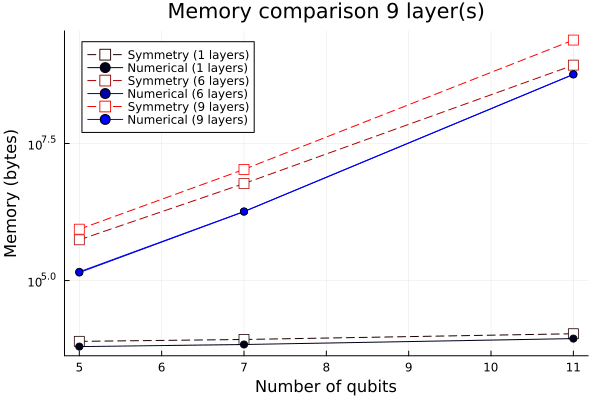

In [21]:
# Figure for memory usage
Plot = plot()

# Plot the performance as a function of parameter `n`
for d in layers
    memory_numerical_n = [memory_numerical[(n, d)] for n in qubits]
    memory_symmetry_n = [memory_symmetry[(n, d)] for n in qubits]
    # Display d in different gradient of color
    colors_numerical = [RGB(0, 0, d/maximum(layers)) for _ in 1:length(qubits)]
    colors_symmetry = [RGB(d/maximum(layers), 0, 0) for _ in 1:length(qubits)]
    

    plot!(
        Plot, qubits, memory_symmetry_n, 
        label="Symmetry ($d layers)" ,marker=:square, color=colors_symmetry,
        yscale=:log10, markersize=5,
        markercolor=RGBA(1, 1, 1, 0), markerstrokecolor=colors_symmetry, linestyle=:dash
        # color=colors_symmetry, markercolor=:transparent,
    )
    plot!(Plot, qubits, memory_numerical_n, 
        label="Numerical ($d layers)" ,marker=:circle, color=colors_numerical,
        yscale=:log10, 
        xlabel="Number of qubits", ylabel="Memory (bytes)", title="Memory comparison $d layer(s)"
    )
    plot!(Plot, legend=:topleft)
end
display(Plot)